<h1 style="font-size:3rem;color:orange;">Directing User Subscriptions📱</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Import Data

In [2]:
df_users = pd.read_csv("../data/processed/new_app-user-data.csv")

### Data Peek 👀

In [3]:
df_users.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


In [4]:
df_users.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
count,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,...,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000,49859.000000
mean,186884.281855,3.028902,12.559277,31.733007,20.824545,0.107764,0.172065,0.506448,0.165005,0.516958,...,0.014180,0.013338,0.013037,0.008163,0.007401,6.198139,0.353316,0.924868,0.173991,0.787060
std,107769.969568,2.031992,7.440773,10.806268,14.778414,0.310085,0.377441,0.499963,0.371189,0.499717,...,0.118234,0.114717,0.113433,0.089981,0.085710,3.655980,1.378185,1.216047,0.607124,0.677072
min,13.000000,0.000000,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93525.500000,1.000000,5.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,187148.000000,3.000000,14.000000,29.000000,18.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000
75%,279976.000000,5.000000,19.000000,37.000000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,1.000000
max,373662.000000,6.000000,23.000000,101.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,10.000000,5.000000,3.000000,3.000000


- Above we note that we currently have 49,859 samples for model training and evaluation
- With 47 numerical & categorical features combined

# Data Pre-processing <img src="../../images/processing.gif" width="52" alt="Processing">

### Remove the label from the features

In [5]:
label = df_users['enrolled']
df_users = df_users.drop(columns = 'enrolled')

### Transformations

In [6]:
# Take the log of 'numscreens' to address skew
df_users['log_numscreens'] = np.log(df_users['numscreens'])

# Drop the previous values 
df_users.drop('numscreens', axis=1, inplace=True)

### Feature Selection

The following function leverages a model's feature importance scores and [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to calculate threshold scores for feature selection. We persist [results](../experiments/feature_thresholds/xgb_feat_threshold_scores.csv) to avoid duplicate runs.

In [7]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_threshold_scores(X_train, y_train, X_test, y_test, model, file_name, run_function):
    """
    Generates scores for feature importance thresholds to be used in feature selection.
    Accepts the training & test sets, the trained model, a file_name, & a boolean to execute.
    Writes a CSV file with the threshold, number of remaining features, & model evaluation metrics.
    """
    if run_function == False: return
    results = []
    # Fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # Select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        # Apply selection to datasets
        select_X_train = selection.transform(X_train.values)
        select_X_test = selection.transform(X_test.values)
        num_features = select_X_train.shape[1]
        # Define the selection_model to use
        selection_model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)
        # Train model
        selection_model.fit(select_X_train, y_train)
        # Evaluate model
        y_predict = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, y_predict)
        precision = precision_score(y_test, y_predict)
        recall = recall_score(y_test, y_predict)
        f1 = f1_score(y_test, y_predict)
        # Results
        results.append([thresh, num_features, accuracy, precision, recall, f1])
        
    # Create a DataFrame from the results list
    column_names = ["Threshold", "Num_Features", "Accuracy", "Precision", "Recall", "F1_Score"]
    threshold_results_df = pd.DataFrame(results, columns=column_names)
    # Save the DataFrame to a CSV file
    threshold_results_df.to_csv(file_name, index=False)  

### Split the dataset into training and test sets

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users, label,
                                                    test_size = 0.2,
                                                    stratify=label, 
                                                    random_state = 42)
print(X_train.shape)
print(X_test.shape)

(39887, 48)
(9972, 48)


### Filter model data

In [9]:
# Purge user identification, persist to associate the prediction to the user it came from 
train_identifier = X_train['user']
X_train = X_train.drop(columns = ['user'])

test_identifier = X_test['user']
X_test = X_test.drop(columns = ['user'])

### Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler

def standard_scale(your_df, columns_to_exclude):
    """
    Performs standard scaling on numercial columns within a DataFrame.
    Accepts the DataFrame and an array of column names to exclude.
    Returns the modified DataFrame.
    """
    # Identify columns to be excluded from scaling
    excluded_columns = [col for col in your_df.columns if any(substring in col for substring in columns_to_exclude)]
    # Columns to be standardized
    columns_to_scale = [col for col in your_df.columns if col not in excluded_columns]
    # Instantiate the scaler
    standard_scaler_X = StandardScaler()
    # Scale the columns
    scaled_features = standard_scaler_X.fit_transform(your_df[columns_to_scale])
    # Convert scaled features into DataFrame
    scaled_df = pd.DataFrame(scaled_features, columns=columns_to_scale, index=your_df.index)
    # Concatenate the scaled features with the excluded columns to get the final dataframe
    your_df = pd.concat([scaled_df, your_df[excluded_columns]], axis=1)

    return your_df

In [11]:
binary_columns_to_exclude = [col for col in df_users.columns if set(df_users[col]) == {0, 1}]

X_train = standard_scale(X_train, binary_columns_to_exclude)
X_test = standard_scale(X_test, binary_columns_to_exclude)

# Model Building 🤖

### Training Data

In [12]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=0.2, 
                                                                stratify=y_train, 
                                                                random_state=42)
print(X_train.shape)
print(X_validation.shape)

(31909, 47)
(7978, 47)


### Training Data Combined

For cross-validation and final model training

In [13]:
# Concatenate the training and validation feature datasets vertically
X_train_and_validation = pd.concat([X_train, X_validation], axis=0).reset_index(drop=True)

# Concatenate the training and validation label datasets vertically
y_train_and_validation = pd.concat([y_train, y_validation], axis=0).reset_index(drop=True)

### Metrics Function

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_scores_and_concat(y_test, y_predict, model_name, results_dataframe): 
    """
    Evaluates model scores and concatenates results to a DataFrame.
    """
    # Get scores
    accuracy = accuracy_score(y_test, y_predict)   # CorrectPredicts/TotalPredicts  
    precision = precision_score(y_test, y_predict) # TP/(TP+FP)
    recall = recall_score(y_test, y_predict)       # TP/(TP+FN)
    f1 = f1_score(y_test, y_predict)               # 2*(precision*recall)/(precision+recall)
    # Transfer scores to a DataFrame
    new_results = pd.DataFrame([[model_name, accuracy, precision, recall, f1]],
                       columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    # Concatenate results to the results_dataframe vertically
    results_dataframe = pd.concat([results_dataframe, new_results], axis=0).reset_index(drop=True)
    
    return results_dataframe

## Logistic Regression 📈

### Training

In [15]:
from sklearn.linear_model import LogisticRegression

# Penalty 'l1' Lasso regularization
lr_model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

lr_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='saga')

### Evaluation

In [16]:
from sklearn.model_selection import cross_val_score

# Make predictions from the validation set
y_predict = lr_model.predict(X_validation)

# Initialize a results DataFrame
df_results = pd.DataFrame()

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'LogisticRegression (Lasso)', df_results)

# Perform k-fold cross-validation, here with 5 folds
accuracies = cross_val_score(estimator=lr_model, X=X_train_and_validation, y=y_train_and_validation, cv=5)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 76.60%
Confidence Interval: +- 0.81%



,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression (Lasso),0.774129,0.773649,0.783222,0.778406


## Random Forest Classifier 🌳

### Training

In [17]:
from sklearn.ensemble import RandomForestClassifier

# 100 Trees
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

### Evaluation

In [18]:
# Make predictions from the validation set
y_predict = rf_model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'RandomForestClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 5 folds
accuracies = cross_val_score(estimator=rf_model, X=X_train_and_validation, y=y_train_and_validation, cv=5)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 77.79%
Confidence Interval: +- 1.12%



,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression (Lasso),0.774129,0.773649,0.783222,0.778406
1,RandomForestClassifier (n=100),0.782276,0.791203,0.774561,0.782794


## XGBoost Classifier 🚀


### Training

In [19]:
from xgboost import XGBClassifier

# 100 Stages
xgb_model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluation

In [20]:
# Make predictions from the validation set
y_predict = xgb_model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'XGBClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 5 folds
accuracies = cross_val_score(estimator=xgb_model, X=X_train_and_validation, y=y_train_and_validation, cv=5)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 77.97%
Confidence Interval: +- 0.65%



,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression (Lasso),0.774129,0.773649,0.783222,0.778406
1,RandomForestClassifier (n=100),0.782276,0.791203,0.774561,0.782794
2,XGBClassifier (n=100),0.787666,0.801749,0.771591,0.786381


## Save Data 💾

In [21]:
# Create a directory to save results
directory = "../experiments"
if not os.path.exists(directory): os.makedirs(directory)

df_results.to_csv("../experiments/baseline_metrics_001.csv", index=False)

## Baseline Model Evaluation <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExNDM1bWRnOW05MW9nNW1kNXJqbDNlMnRpMjFwZ2hpMHJuaWZ2Nms0eSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/ZOKhyP4ai1guMHhwFB/giphy.gif" width="44" alt="Stat Bars">

Above we discover the [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) algorithm has provided some of our best estimates thus far as a baseline model and we proceed with a further evaluation of the model

In [22]:
# Select model
model = xgb_model

### Confusion Matrix

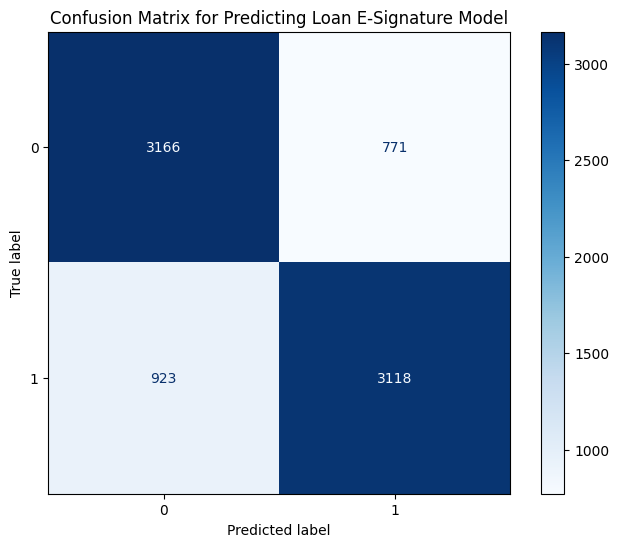

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def sklearn_confusion_matrix(y_test, y_predict):
    """
    Generates a simple confusion matrix. 
    Accepts the test set and predicted labels from the model.
    Displays the plot.
    """
    # Create a confusion matrix with the labels and our model's predictions
    conf_matrix = confusion_matrix(y_test, y_predict)
    # Create the plot
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title='Confusion Matrix for Predicting Loan E-Signature Model')
    display.plot(ax=ax, cmap='Blues', values_format='d')
    plt.show()

  
sklearn_confusion_matrix(y_validation, y_predict)

### K-Fold Cross Validation

Further estimate how well the model is likely to generalize to unseen data


In [24]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
print(accuracies)

Cross Validated Accuracy: 78.14%
Confidence Interval: +- 1.66%

[0.78315367 0.78114816 0.76560541 0.78616195 0.78089747 0.7896716
 0.7778892  0.77081244 0.79613842 0.78284855]


### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.87


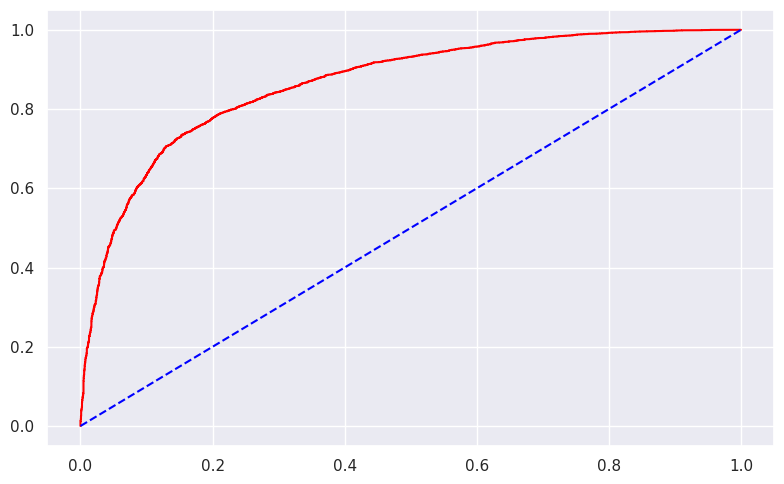

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn.objects as so

def plot_roc_curve(X_test, y_test, model):
   """
   Function for plotting the ROC Curve.
   Accepts the test features, labels, and the trained model.
   Displays the plot and returns the AUC score. 
   """
   # Generate data for a 45 degree line
   noskill_probabilities = [0 for number in range(len(y_test))]
   # Predict the probabilities of the positive class
   probabilities_posclass = model.predict_proba(X_test)[:, 1]
   # Calculate data for horizontal line
   falsepositive_rate_noskill, truepositive_rate_noskill, _ = roc_curve(y_test, noskill_probabilities)
   # Calculate data for ROC curve
   falsepositive_rate, truepositive_rate, _ = roc_curve(y_test, probabilities_posclass)
   # Calculate AUC
   auc = roc_auc_score(y_test, probabilities_posclass)
   # Display AUC
   print("AUC (Area Under the ROC Curve): {:.2f}".format(auc))
   # Plot with Seaborn Objects
   plt = (so.Plot()
      .add(so.Line(color='red'), x =falsepositive_rate, y=truepositive_rate)
      .add(so.Line(color='blue', linestyle='dashed'), x=falsepositive_rate_noskill, y=truepositive_rate_noskill)
      .layout(size = (8,5))
      )
   plt.show()
   
   return auc


auc_score = plot_roc_curve(X_validation, y_validation, model)

We note the model's discriminatory power is very good

### Feature Importances

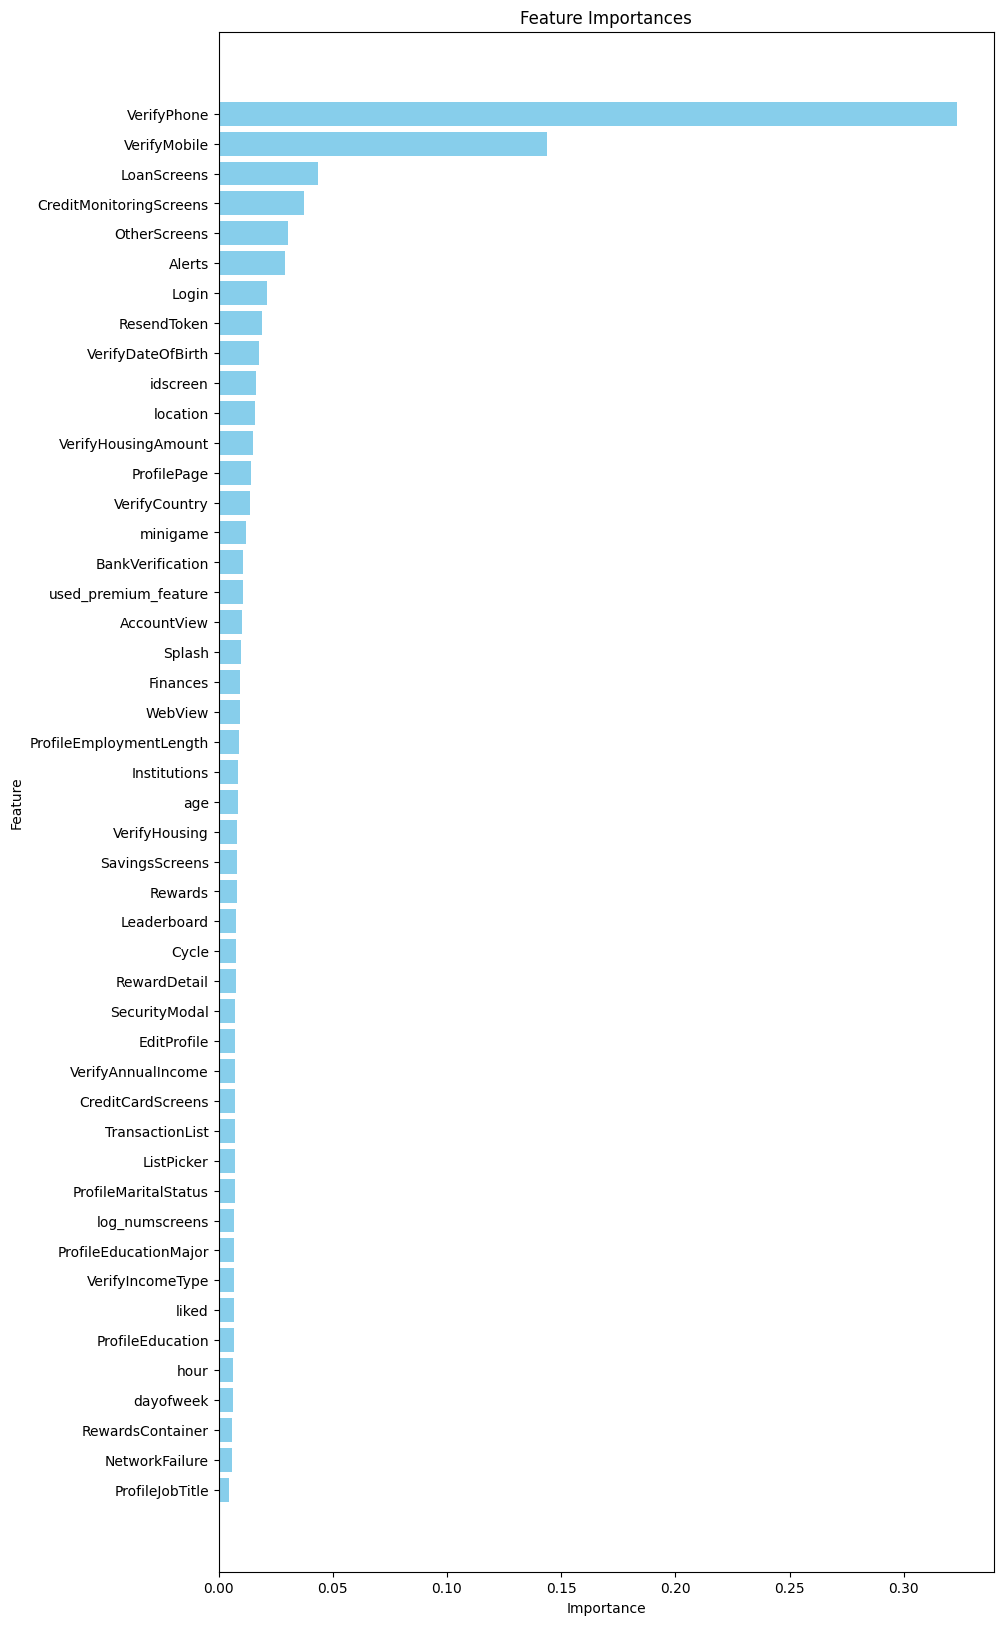

,Feature,Importance
14,VerifyPhone,0.323121
27,VerifyMobile,0.143793
7,LoanScreens,0.043434
5,CreditMonitoringScreens,0.037495
3,OtherScreens,0.030383
25,Alerts,0.029308
39,Login,0.021430
43,ResendToken,0.019127
16,VerifyDateOfBirth,0.017787
20,idscreen,0.016361


In [26]:
def plot_feature_importance(X_train, model):
    """
    Function to plot feature importance.
    Accepts the training features and trained model.
    Displays the plot and returns a DataFrame of features and their importance scores.
    """
    # Extract feature names from the DataFrame
    features = X_train.columns.tolist()
    # Create a DataFrame with feature names and their importance
    feature_df = pd.DataFrame({
      'Feature': features,
      'Importance': model.feature_importances_
      })
    # Sort the DataFrame by importance in descending order
    feature_df = feature_df.sort_values(by='Importance', ascending=False)
    # Plotting
    plt.figure(figsize=(10, 20)) 
    plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis() # Place highest importance at top
    plt.show()

    return feature_df


feature_df = plot_feature_importance(X_train, model)
# Adjust for full list
feature_df.head(10)

### Feature Selection

- Generate Threshold Scores

In [27]:
file_name = "../experiments/feature_thresholds/xgb_feat_threshold_scores.csv"

get_threshold_scores(X_train, y_train,X_validation, y_validation, model, file_name, False)

- Inspect Results

In [28]:
threshold_results_df = pd.read_csv(file_name)

# Set the display format for float values to 10 decimal places
pd.set_option('display.float_format', '{:.10f}'.format)

# Adjust for full list
threshold_results_df.head(10)

,Threshold,Num_Features,Accuracy,Precision,Recall,F1_Score
0,0.0047031157,47,0.7876660817,0.8017485215,0.7715911903,0.7863808323
1,0.0056918184,46,0.7839057408,0.7969751346,0.7693640188,0.7829262151
2,0.0058860930,45,0.7831536726,0.7972729612,0.7668893838,0.7817860747
3,0.0062230440,44,0.7837803961,0.7975334018,0.7681267013,0.7825538888
4,0.0065336134,43,0.7865379794,0.8003597122,0.7708487998,0.7853271146
5,0.0065942880,42,0.7869140135,0.8028460543,0.7678792378,0.7849734379
6,0.0068151834,41,0.7872900476,0.8039419087,0.7671368473,0.7851082690
7,0.0069152920,40,0.7895462522,0.8065939772,0.7688690918,0.7872798682
8,0.0069615660,39,0.7876660817,0.8048843856,0.7666419203,0.7852978454
9,0.0069784450,38,0.7879167711,0.8048274072,0.7673843108,0.7856599949


In [29]:
# Reset display option to default value
pd.reset_option('display.float_format')

- Select Features 

In [30]:
threshold = 0.0073200840

# Define features under the threshold to remove
features_to_remove_df = feature_df[feature_df['Importance'] < threshold]
columns_to_drop = features_to_remove_df['Feature'].values.tolist()

print(columns_to_drop)

['CreditCardScreens', 'TransactionList', 'ListPicker', 'ProfileMaritalStatus', 'log_numscreens', 'ProfileEducationMajor', 'VerifyIncomeType', 'liked', 'ProfileEducation', 'hour', 'dayofweek', 'RewardsContainer', 'NetworkFailure', 'ProfileJobTitle']


In [31]:
# Drop the features from the datasets
X_train.drop(columns=columns_to_drop, axis=1, inplace=True)
X_validation.drop(columns=columns_to_drop, axis=1, inplace=True)
X_train_and_validation.drop(columns=columns_to_drop, axis=1, inplace=True)
X_test.drop(columns=columns_to_drop, axis=1, inplace=True)

print("Number of Features: ", X_train.shape[1])

Number of Features:  33


- Retraining & Evaluation

In [32]:
model.fit(X_train, y_train)

# Make predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'XGBClassifier (n=100, feat_thresh=0.0073200840)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 78.15%
Confidence Interval: +- 1.61%



,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression (Lasso),0.774129,0.773649,0.783222,0.778406
1,RandomForestClassifier (n=100),0.782276,0.791203,0.774561,0.782794
2,XGBClassifier (n=100),0.787666,0.801749,0.771591,0.786381
3,"XGBClassifier (n=100, feat_thresh=0.0073200840)",0.790925,0.805720,0.773818,0.789447


We observe a slight improvement in our scores as a result of feature selection and continue with hyperparameter optimization

## Model Tuning 🎯

Here we utilize Hyperopt for model tuning to take advantage of Bayesian Optimization. 

## Final Model Training 🦾

## Final Model Evaluation <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExNDM1bWRnOW05MW9nNW1kNXJqbDNlMnRpMjFwZ2hpMHJuaWZ2Nms0eSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/ZOKhyP4ai1guMHhwFB/giphy.gif" width="44" alt="Stat Bars">

## Save Model 💾

## Process Results 🔄

Here we format the final results from our model's predictions to the user this data came from. Though in the future we will not have 'enrolled' data for the deployed model's predictions, a similar process can be utilized. This enables the sales team to identify users the model has estimated unlikely to subscribe to paid subscriptions. 

In [ ]:
# Concatenate test labels to the user they came from
final_results = pd.concat([y_test, test_identifier], axis =1).dropna()
# Add predicted results from the model
final_results['predicted_results'] = y_predict
final_results = final_results[['user', 'enrolled', 'predicted_results']].reset_index(drop=True)

# Adjust as needed
final_results.head(10)

### Save Data 💾

Persist final results and a list of users our model has estimated to be unlikely to enroll in the paid subscription

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table
from datetime import datetime
import csv

# Create a directory to save results if it doesn't exist
directory = "../data/results"
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Get the current date and time, remove milliseconds
datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save final results to a .csv file 
final_results.to_csv(f"../data/results/final_results_{datetime}.csv")

# Filter the DataFrame for a list of users unlikely to subscribe
final_results = final_results[final_results.predicted_results == 0].copy()
unlikely_to_subscribe = final_results.copy().drop(columns = ['enrolled', 'predicted_results'])

# Save the list of users unlikely to subscribe to a .csv file
unlikely_to_subscribe.to_csv(f"../data/results/users_unlikely_to_subscribe_{datetime}.csv")

# Define paths to convert
csv_file = f"../data/results/users_unlikely_to_subscribe_{datetime}.csv"
pdf_file = f"../data/results/users_unlikely_to_subscribe_{datetime}.pdf"

# Convert the .csv file 
data = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)

# Create a PDF document
doc = SimpleDocTemplate(pdf_file, pagesize=letter)

# Create a table from the CSV data
table = Table(data)

# Add the table to the document
doc.build([table])